# Contribution Functions

Contribution functions are helpful to understand either 1) what molecules are contributing to the overall resultant spectrum, or 2) at what pressure levels you are sensitive to in thermal emission

In this tutorial you will learn how to get molecular contribution plots and thermal contribution heatmaps. This will help you in analyzing your spectra. 

In [1]:
import picaso.justdoit as jdi
import picaso.justplotit as jpi
jpi.output_notebook()

Loading BokehJS ...

## Initial Model Setup

Let's do a basic run with a thermal emission and transmission spectrum

In [2]:
opa=jdi.opannection()
case1 = jdi.inputs()
case1.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
case1.gravity(radius = 1, radius_unit=jdi.u.Unit('R_jup'),
           mass = 1, mass_unit=jdi.u.Unit('M_jup'))
case1.phase_angle(0)
case1.atmosphere(filename = jdi.HJ_pt(), delim_whitespace=True)
df = case1.spectrum(opa, calculation='thermal+transmission', full_output=True)
full_output=df['full_output']

/home/nbatalh1/codes/picaso/picaso/atmsetup.py:190: UserWarning: Ignoring kz in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


## Individual Species Contribution 

What does get contribution output?? 

`taus_per_layer`
- Each dictionary entry is a nlayer x nwave that represents the per layer optical depth for that molecule. 

`cumsum_taus`
- Each dictionary entry is a nlevel x nwave that represents the cumulative summed opacity for that molecule. 

`tau_p_surface` 
- Each dictionary entry is a nwave array that represents the pressure level where the cumulative opacity reaches the value specified by the user through `at_tau`.

Note: If you do not see a molecule that you have added as input, check to make sure it is propertly formatted (e.g. Sodium must be Na not NA, Titanium Oxide must be TiO not TIO)

In [3]:
out = jdi.get_contribution(case1, opa, at_tau=1)

In [4]:
out.keys()

dict_keys(['taus_per_layer', 'cumsum_taus', 'tau_p_surface'])

In [5]:
jpi.show(jpi.molecule_contribution(out, opa, plot_width=700, x_axis_type='log'))

In [6]:
out['taus_per_layer']['H2O'].shape

(89, 28717)

## See Species Contribution w/ "leave-one-out" Method

Though the tau~1 surface is very informative it is sometimes easier to just look at your spectrum with the opacity contribution of a single molecule removed. 

In [7]:
#atmo
w,f,l =[],[],[]
for iex in ['CH4','H2O','CO2',None]:
    case1.atmosphere(filename = jdi.HJ_pt(),exclude_mol=iex, delim_whitespace=True)
    df= case1.spectrum(opa, full_output=True,calculation='transmission') #note the new last key 
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f+=[rprs2]
    if iex==None: 
        leg='all'
    else: 
        leg = f'No {iex}'
    l+=[leg]
jpi.show(jpi.spectrum(w,f,legend=l))

/home/nbatalh1/codes/picaso/picaso/atmsetup.py:190: UserWarning: Ignoring kz in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


## Transmission Contribution Function 

The transmission contribution function allows you to determine what pressures your model is sensitive to. The transmission contribution function is defined by Eqn. 8 [Molliere et al 2019](https://arxiv.org/pdf/1904.11504.pdf).

Note that this will take a little to run as it is effectively re-computing a transmission spectrum with each layer removed. By comparing the original spectrum to a spectrum with the layer removed, we can see how much that layer contributes to the overall spectrum. 

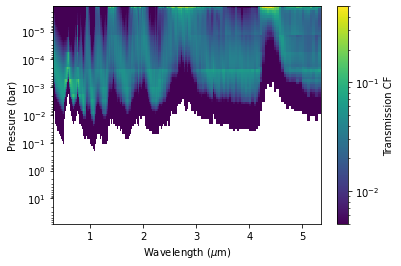

In [8]:
fig, ax, um, CF_bin = jpi.transmission_contribution(full_output ,R=100, 
                                       norm=jpi.colors.LogNorm(vmin=0.005, vmax=0.5))

## Thermal Contribution Function

Contribution functions give us an understanding of where pressures flux is being emitted (e.g. [Lothringer et al 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aadd9e#apjaadd9es3-3-1) Figure 12) 

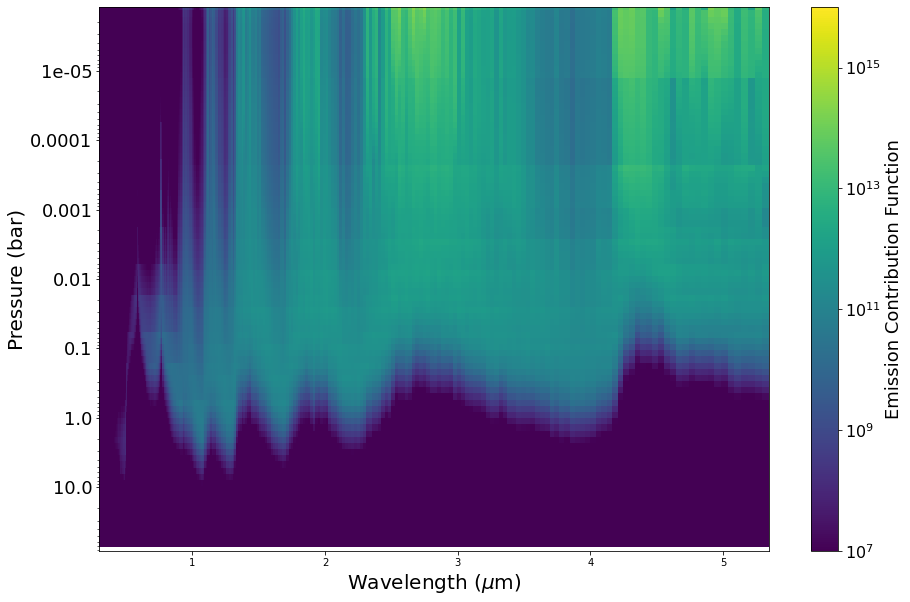

In [9]:
fig, ax, CF = jpi.thermal_contribution(df['full_output'], 
                                       norm=jpi.colors.LogNorm(vmin=1e7, vmax=1e16))